# Interactive Testing: Atlas Analysis Modules

This notebook allows you to interactively test the `AtlasAggregation` and `RegionalDamage` analysis modules with your own lesion files and atlas directories.

## Features
- Load and visualize lesion data
- Test regional damage analysis (lesion-atlas overlap)
- Compare different aggregation methods (mean, sum, percent, volume)
- Visualize results with interactive plots
- Chain multiple analyses together

## 1. Setup and Imports

In [1]:
# Import LDK modules
from ldk import LesionData
from ldk.analysis import AtlasAggregation, RegionalDamage

# Import scientific computing libraries
import numpy as np
import nibabel as nib
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Configure matplotlib for inline display
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

print("✓ All imports successful!")
print(f"LesionData version: {LesionData.__module__}")
print(f"AtlasAggregation: {AtlasAggregation.__name__}")
print(f"RegionalDamage: {RegionalDamage.__name__}")

✓ All imports successful!
LesionData version: ldk.core.lesion_data
AtlasAggregation: AtlasAggregation
RegionalDamage: RegionalDamage


## 2. Configure Input Paths

Update these paths to point to your lesion file and atlas directory.

In [2]:
# ===== CONFIGURE THESE PATHS =====

# Path to your lesion NIfTI file (must be in MNI152 space)
lesion_path = "/media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/raw/lesion_masks/acuteinfarct/CAS_005_infarct.nii.gz"

# Path to directory containing atlas files
# Each atlas should have:
#   - .nii.gz file (the atlas image)
#   - _labels.txt file (region labels)
atlas_dir = "/media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/atlases"

# Optional: path to anatomical scan (if available)
anatomical_path = None  # or "/path/to/anatomical.nii.gz"

print(f"Lesion file: {lesion_path}")
print(f"Atlas directory: {atlas_dir}")
print(f"Anatomical: {anatomical_path if anatomical_path else 'None'}")

Lesion file: /media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/raw/lesion_masks/acuteinfarct/CAS_005_infarct.nii.gz
Atlas directory: /media/moritz/Storage2/projects_marvin/202509_PSCI_DISCONNECTIVITY/data/atlases
Anatomical: None


## 3. Load and Inspect Lesion Data

In [3]:
# Load lesion data
lesion_data = LesionData.from_nifti(lesion_path=lesion_path, anatomical_path=anatomical_path)

# Display basic information
print("=" * 60)
print("LESION DATA SUMMARY")
print("=" * 60)
print(f"Shape: {lesion_data.lesion_img.shape}")
print(f"Data type: {lesion_data.lesion_img.get_fdata().dtype}")
print(f"Affine:\n{lesion_data.affine}")

# Lesion statistics
lesion_array = lesion_data.lesion_img.get_fdata()
print(f"\nLesion statistics:")
print(f"  Min value: {lesion_array.min():.4f}")
print(f"  Max value: {lesion_array.max():.4f}")
print(f"  Non-zero voxels: {np.sum(lesion_array > 0):,}")
print(f"  Percentage non-zero: {100 * np.sum(lesion_array > 0) / lesion_array.size:.2f}%")

# Check if binary
unique_vals = np.unique(lesion_array)
is_binary = np.all(np.isin(unique_vals, [0, 1]))
print(f"  Is binary (0/1): {is_binary}")
if not is_binary:
    print(
        f"  Unique values: {unique_vals[:10]}..."
        if len(unique_vals) > 10
        else f"  Unique values: {unique_vals}"
    )

print("\n✓ Lesion data loaded successfully!")

LESION DATA SUMMARY
Shape: (182, 218, 182)
Data type: float64
Affine:
[[  -1.   -0.    0.   90.]
 [  -0.    1.   -0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]

Lesion statistics:
  Min value: 0.0000
  Max value: 1.0000
  Non-zero voxels: 13,484
  Percentage non-zero: 0.19%
  Is binary (0/1): True

✓ Lesion data loaded successfully!


### Visualize Lesion

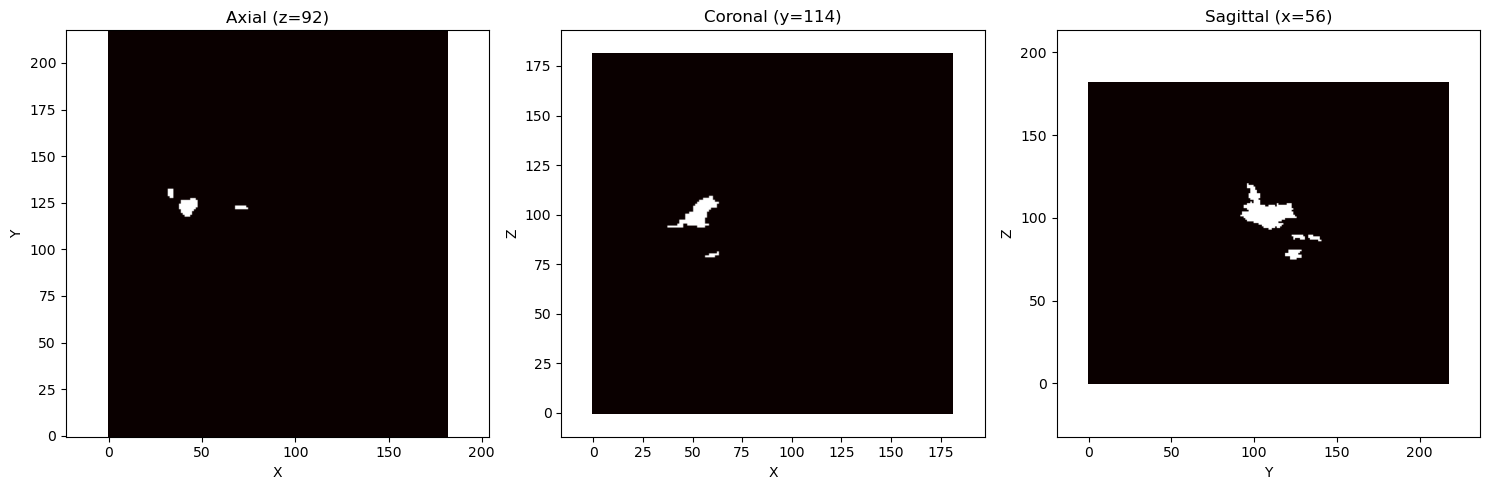

In [4]:
# Visualize lesion in three orthogonal views
lesion_array = lesion_data.lesion_img.get_fdata()

# Find center of mass for slicing
coords = np.where(lesion_array > 0)
if len(coords[0]) > 0:
    center_x = int(np.mean(coords[0]))
    center_y = int(np.mean(coords[1]))
    center_z = int(np.mean(coords[2]))
else:
    center_x, center_y, center_z = [s // 2 for s in lesion_array.shape]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Axial view
axes[0].imshow(lesion_array[:, :, center_z].T, cmap="hot", origin="lower")
axes[0].set_title(f"Axial (z={center_z})")
axes[0].set_xlabel("X")
axes[0].set_ylabel("Y")
axes[0].axis("equal")

# Coronal view
axes[1].imshow(lesion_array[:, center_y, :].T, cmap="hot", origin="lower")
axes[1].set_title(f"Coronal (y={center_y})")
axes[1].set_xlabel("X")
axes[1].set_ylabel("Z")
axes[1].axis("equal")

# Sagittal view
axes[2].imshow(lesion_array[center_x, :, :].T, cmap="hot", origin="lower")
axes[2].set_title(f"Sagittal (x={center_x})")
axes[2].set_xlabel("Y")
axes[2].set_ylabel("Z")
axes[2].axis("equal")

plt.tight_layout()
plt.show()

## 4. Inspect Atlas Directory

In [5]:
# List all files in atlas directory
atlas_path = Path(atlas_dir)

if not atlas_path.exists():
    print(f"❌ Atlas directory does not exist: {atlas_path}")
else:
    print("=" * 60)
    print("ATLAS DIRECTORY CONTENTS")
    print("=" * 60)

    # Find NIfTI files
    nifti_files = sorted(list(atlas_path.glob("*.nii.gz")) + list(atlas_path.glob("*.nii")))

    # Find label files
    label_files = sorted(list(atlas_path.glob("*_labels.txt")) + list(atlas_path.glob("*.txt")))

    print(f"\nNIfTI files ({len(nifti_files)}):")
    for f in nifti_files:
        size_mb = f.stat().st_size / (1024 * 1024)
        print(f"  - {f.name} ({size_mb:.2f} MB)")

    print(f"\nLabel files ({len(label_files)}):")
    for f in label_files:
        n_lines = len(f.read_text().strip().split("\n"))
        print(f"  - {f.name} ({n_lines} lines)")

    # Try to discover atlas pairs
    print("\n" + "=" * 60)
    print("ATLAS PAIRS (NIfTI + Labels)")
    print("=" * 60)

    for nifti_path in nifti_files:
        base_name = nifti_path.stem.replace(".nii", "")

        # Look for matching label file
        label_candidates = [
            atlas_path / f"{base_name}_labels.txt",
            atlas_path / f"{base_name}.txt",
        ]

        label_path = None
        for candidate in label_candidates:
            if candidate.exists():
                label_path = candidate
                break

        if label_path:
            n_regions = len(label_path.read_text().strip().split("\n"))
            print(f"✓ {base_name}")
            print(f"    NIfTI: {nifti_path.name}")
            print(f"    Labels: {label_path.name} ({n_regions} regions)")
        else:
            print(f"⚠ {base_name}")
            print(f"    NIfTI: {nifti_path.name}")
            print(f"    Labels: NOT FOUND")

    print(f"\n✓ Atlas directory scanned successfully!")

ATLAS DIRECTORY CONTENTS

NIfTI files (14):
  - BrainstemNucleiAtlas_MNI.nii.gz (0.07 MB)
  - Buckner7.nii.gz (0.03 MB)
  - DiencephalicNucleiAtlas_MNI.nii.gz (0.06 MB)
  - HCP1065_thr0p1.nii.gz (1.07 MB)
  - JHU_ICBM_1mm.nii.gz (0.05 MB)
  - NettekovenAsym32_space-MNI152NLin6AsymC_dseg.nii (1.26 MB)
  - Schaefer2018_1000Parcels_7Networks_order_FSLMNI152_1mm.nii.gz (0.34 MB)
  - Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz (0.22 MB)
  - Schaefer2018_200Parcels_7Networks_order_FSLMNI152_1mm.nii.gz (0.25 MB)
  - Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz (0.28 MB)
  - Tian_Subcortex_S1_3T_2009cAsym.nii.gz (0.01 MB)
  - Tian_Subcortex_S2_3T_2009cAsym.nii.gz (0.01 MB)
  - Tian_Subcortex_S3_3T_2009cAsym.nii.gz (0.01 MB)
  - Tian_Subcortex_S4_3T_2009cAsym.nii.gz (0.01 MB)

Label files (27):
  - BrainstemNucleiAtlas_MNI_labels.txt (76 lines)
  - BrainstemNucleiAtlas_MNI_labels.txt (76 lines)
  - Buckner7_labels.txt (7 lines)
  - Buckner7_labels.txt (7 lines)


## 5. Test RegionalDamage Analysis

Compute lesion overlap (percent damage) for each brain region.

In [ ]:
atlas_names = [
    "Tian_Subcortex_S1_3T_2009cAsym",
    "HCP1065_thr0p1",
    "Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm",
]

# Create RegionalDamage analysis
regional_damage = RegionalDamage(atlas_names=atlas_names)

# Run analysis
result = regional_damage.run(lesion_data)

print("=" * 60)
print("REGIONAL DAMAGE ANALYSIS RESULTS")
print("=" * 60)
print(f"Analysis completed successfully!")
print(f"Results stored in: result.results['RegionalDamage']")
print(f"Number of regions: {len(result.results['RegionalDamage'])}")
print("\n✓ RegionalDamage analysis complete!")

/media/moritz/Storage2/projects_marvin/lesion_decoding_toolkit/src/ldk/analysis/base.py:106: UserWarning: Atlas 'Tian_Subcortex_S1_3T_2009cAsym' will be resampled to match source data.
Source shape: (182, 218, 182), Atlas shape: (97, 115, 97)
  analysis_results = self._run_analysis(lesion_data)


REGIONAL DAMAGE ANALYSIS RESULTS
Analysis completed successfully!
Results stored in: result.results['RegionalDamage']
Number of regions: 180

✓ RegionalDamage analysis complete!


In [7]:
from ldk.io.fetch import list_available_atlases

list_available_atlases()

['harvard-oxford-cortical.nii',
 'aal3.nii',
 'schaefer2018-100parcels-7networks.nii',
 'schaefer2018-400parcels-7networks.nii']

In [8]:
result.results["RegionalDamage"]

{'Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_1': 0.0,
 'Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_2': 0.0,
 'Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_3': 0.0,
 'Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_4': 0.0,
 'Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_5': 0.0,
 'Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_6': 0.0,
 'Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_7': 0.0,
 'Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_8': 0.0,
 'Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_9': 0.0,
 'Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_SomMot_1': 0.0,
 'Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_SomMot_2': 0.0,
 'Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_SomMot_3': 0.0,
 'Schae

### View Top Damaged Regions

In [9]:
# Convert results to DataFrame for easier viewing
damage_results = result.results["RegionalDamage"]
df = pd.DataFrame(list(damage_results.items()), columns=["Region", "Percent_Damage"])
df = df.sort_values("Percent_Damage", ascending=False)

# Show top 20 most damaged regions
print("=" * 80)
print("TOP 20 MOST DAMAGED REGIONS")
print("=" * 80)
print(df.head(20).to_string(index=False))

# Show summary statistics
print("\n" + "=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)
print(f"Total regions analyzed: {len(df)}")
print(f"Regions with any damage (>0%): {(df['Percent_Damage'] > 0).sum()}")
print(f"Regions with >50% damage: {(df['Percent_Damage'] > 50).sum()}")
print(f"Regions with >90% damage: {(df['Percent_Damage'] > 90).sum()}")
print(f"\nMean damage: {df['Percent_Damage'].mean():.2f}%")
print(f"Median damage: {df['Percent_Damage'].median():.2f}%")
print(f"Max damage: {df['Percent_Damage'].max():.2f}%")

TOP 20 MOST DAMAGED REGIONS
                                                                                     Region  Percent_Damage
                                                      Tian_Subcortex_S1_3T_2009cAsym_CAU-rh       22.959770
                                                      Tian_Subcortex_S1_3T_2009cAsym_PUT-rh       19.361702
                                                       HCP1065_thr0p1_Corticobulbar_Tract_R       10.131836
                                         HCP1065_thr0p1_Superior_Longitudinal_Fasciculus3_R        9.507238
                                            HCP1065_thr0p1_Corticostriatal_Tract_Superior_R        6.892283
                                                        HCP1065_thr0p1_Arcuate_Fasciculus_R        6.885586
                                         HCP1065_thr0p1_Superior_Longitudinal_Fasciculus2_R        4.232971
                                               HCP1065_thr0p1_Thalamic_Radiation_Superior_R        3.549144


### Visualize Regional Damage

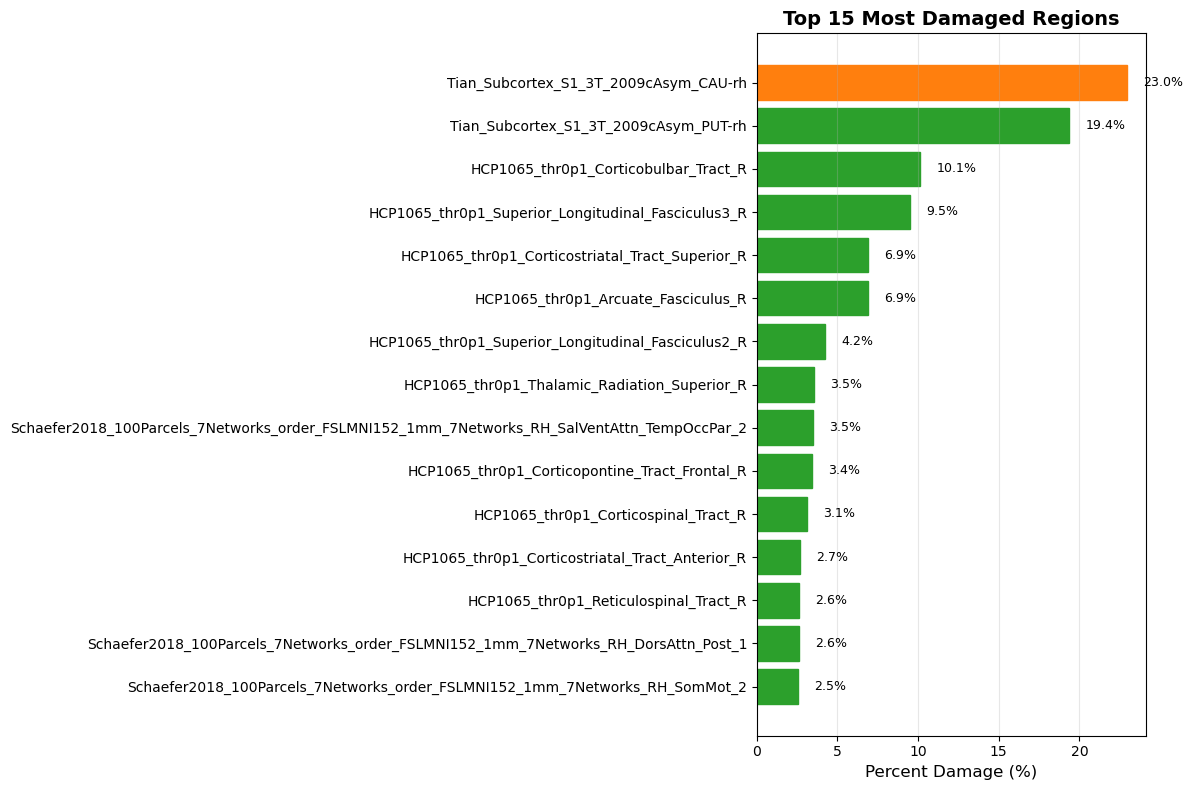

In [10]:
# Plot top 15 damaged regions
top_n = 15
df_top = df.head(top_n)

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(range(len(df_top)), df_top["Percent_Damage"])

# Color bars by damage level
colors = [
    "#d62728" if x > 50 else "#ff7f0e" if x > 20 else "#2ca02c" for x in df_top["Percent_Damage"]
]
for bar, color in zip(bars, colors):
    bar.set_color(color)

ax.set_yticks(range(len(df_top)))
ax.set_yticklabels(df_top["Region"])
ax.set_xlabel("Percent Damage (%)", fontsize=12)
ax.set_title(f"Top {top_n} Most Damaged Regions", fontsize=14, fontweight="bold")
ax.grid(axis="x", alpha=0.3)
ax.invert_yaxis()

# Add value labels on bars
for i, (idx, row) in enumerate(df_top.iterrows()):
    ax.text(row["Percent_Damage"] + 1, i, f"{row['Percent_Damage']:.1f}%", va="center", fontsize=9)

plt.tight_layout()
plt.show()

### NEW: Selective Atlas Processing

Use the `atlas_names` parameter to process only specific atlases from your directory. This is useful when:
- You have many atlases but only need results from specific ones
- You want to compare different atlases side-by-side
- You need faster processing by skipping unnecessary atlases

In [11]:
# Example 1: Process only HCP1065 white matter tracts
print("=" * 80)
print("SELECTIVE ATLAS PROCESSING - HCP1065 Only")
print("=" * 80)

# Process only HCP1065 atlas (white matter tracts)
analysis_selective = RegionalDamage(
    atlas_dir=atlas_dir,
    atlas_names=["HCP1065_thr0p1"],  # Only this atlas
)
result_selective = analysis_selective.run(lesion_data)
results_selective = result_selective.results["RegionalDamage"]

print(f"\nProcessed {len([k for k in results_selective.keys() if 'HCP1065' in k])} HCP1065 regions")
print(f"Skipped all other atlases")

# Show top 10 damaged white matter tracts
df_selective = pd.DataFrame(list(results_selective.items()), columns=["Tract", "Percent_Damage"])
df_selective = df_selective.sort_values("Percent_Damage", ascending=False)

print("\nTop 10 Most Damaged White Matter Tracts:")
print(df_selective.head(10).to_string(index=False))

print("\n" + "=" * 80)

SELECTIVE ATLAS PROCESSING - HCP1065 Only

Processed 64 HCP1065 regions
Skipped all other atlases

Top 10 Most Damaged White Matter Tracts:
                                             Tract  Percent_Damage
              HCP1065_thr0p1_Corticobulbar_Tract_R       10.131836
HCP1065_thr0p1_Superior_Longitudinal_Fasciculus3_R        9.507238
   HCP1065_thr0p1_Corticostriatal_Tract_Superior_R        6.892283
               HCP1065_thr0p1_Arcuate_Fasciculus_R        6.885586
HCP1065_thr0p1_Superior_Longitudinal_Fasciculus2_R        4.232971
      HCP1065_thr0p1_Thalamic_Radiation_Superior_R        3.549144
     HCP1065_thr0p1_Corticopontine_Tract_Frontal_R        3.399324
              HCP1065_thr0p1_Corticospinal_Tract_R        3.088557
   HCP1065_thr0p1_Corticostriatal_Tract_Anterior_R        2.667747
             HCP1065_thr0p1_Reticulospinal_Tract_R        2.612681


Processed 64 HCP1065 regions
Skipped all other atlases

Top 10 Most Damaged White Matter Tracts:
                        

In [12]:
# Example 2: Compare two specific atlases side-by-side
print("=" * 80)
print("SELECTIVE ATLAS PROCESSING - Multiple Atlases")
print("=" * 80)

# Process only Schaefer and HCP1065 atlases
analysis_compare = RegionalDamage(
    atlas_names=["Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm", "HCP1065_thr0p1"],
)
result_compare = analysis_compare.run(lesion_data)
results_compare = result_compare.results["RegionalDamage"]

# Count regions per atlas
schaefer_regions = [k for k in results_compare.keys() if "Schaefer" in k]
hcp_regions = [k for k in results_compare.keys() if "HCP1065" in k]

print(f"\nProcessed:")
print(f"  - Schaefer cortical parcels: {len(schaefer_regions)} regions")
print(f"  - HCP1065 white matter tracts: {len(hcp_regions)} regions")
print(f"  - Total: {len(results_compare)} regions")
print(f"\nSkipped all other atlases in directory")

print("\n" + "=" * 80)

SELECTIVE ATLAS PROCESSING - Multiple Atlases

Processed:
  - Schaefer cortical parcels: 400 regions
  - HCP1065 white matter tracts: 64 regions
  - Total: 464 regions

Skipped all other atlases in directory


Processed:
  - Schaefer cortical parcels: 400 regions
  - HCP1065 white matter tracts: 64 regions
  - Total: 464 regions

Skipped all other atlases in directory



## 6. Test AtlasAggregation with Different Methods

Compare different aggregation methods on the same lesion.

In [13]:
# Test different aggregation methods
methods = ["mean", "sum", "percent", "volume", "median", "std"]
results_dict = {}

print("=" * 60)
print("TESTING AGGREGATION METHODS")
print("=" * 60)

for method in methods:
    print(f"\nTesting method: {method}...")

    analysis = AtlasAggregation(
        atlas_dir=atlas_dir, source="lesion_img", aggregation=method, threshold=0.5
    )

    result = analysis.run(lesion_data)
    results_dict[method] = result.results["AtlasAggregation"]

    print(f"  ✓ {method}: {len(results_dict[method])} regions processed")

print("\n✓ All aggregation methods tested successfully!")

TESTING AGGREGATION METHODS

Testing method: mean...


KeyboardInterrupt: 

### Compare Methods Side-by-Side

COMPARISON FOR REGION: HCP1065_thr0p1_Corticobulbar_Tract_R
 Method       Value
   mean    0.101318
    sum 1245.000000
percent   10.131836
 volume 1245.000000
 median    0.000000
    std    0.301750


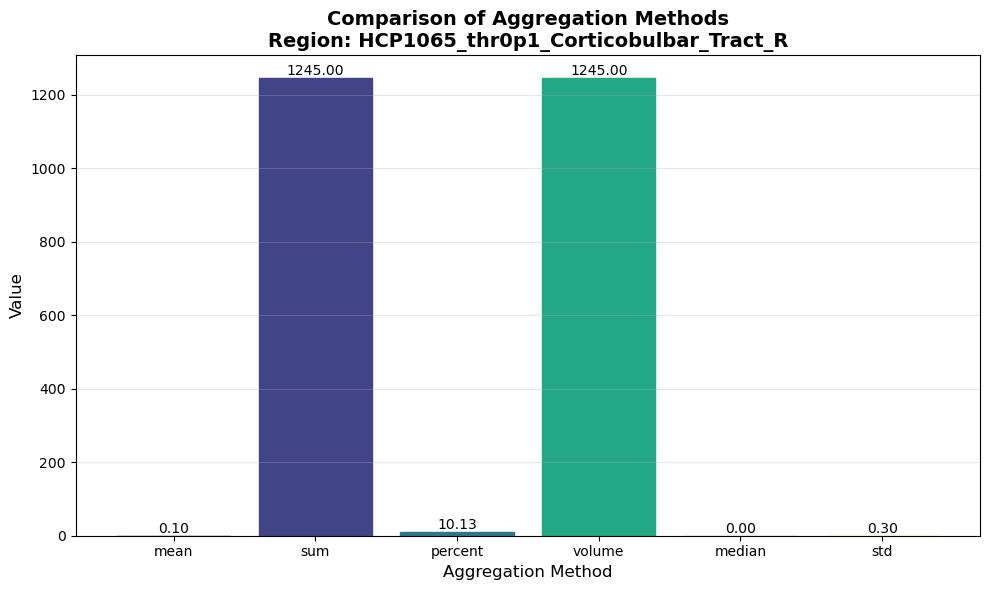

In [12]:
# Pick a representative region to compare
# Get a region that has non-zero values across methods
sample_region = None
for region in results_dict["percent"].keys():
    if results_dict["percent"][region] > 10:  # Region with >10% damage
        sample_region = region
        break

if sample_region:
    print("=" * 80)
    print(f"COMPARISON FOR REGION: {sample_region}")
    print("=" * 80)

    comparison_data = []
    for method in methods:
        value = results_dict[method].get(sample_region, 0)
        comparison_data.append({"Method": method, "Value": value})

    df_comparison = pd.DataFrame(comparison_data)
    print(df_comparison.to_string(index=False))

    # Visualize comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(df_comparison["Method"], df_comparison["Value"])

    # Color bars
    colors = plt.cm.viridis(np.linspace(0, 1, len(methods)))
    for bar, color in zip(bars, colors):
        bar.set_color(color)

    ax.set_ylabel("Value", fontsize=12)
    ax.set_xlabel("Aggregation Method", fontsize=12)
    ax.set_title(
        f"Comparison of Aggregation Methods\nRegion: {sample_region}",
        fontsize=14,
        fontweight="bold",
    )
    ax.grid(axis="y", alpha=0.3)

    # Add value labels on bars
    for i, row in df_comparison.iterrows():
        ax.text(i, row["Value"], f"{row['Value']:.2f}", ha="center", va="bottom", fontsize=10)

    plt.tight_layout()
    plt.show()
else:
    print("No suitable region found for comparison.")

In [17]:
result.results

{'AtlasAggregation': {'Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_1': 0.0,
  'Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_2': 0.0,
  'Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_3': 0.0,
  'Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_4': 0.0,
  'Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_5': 0.0,
  'Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_6': 0.0,
  'Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_7': 0.0,
  'Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_8': 0.0,
  'Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_9': 0.0,
  'Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_10': 0.0,
  'Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_11': 0.0,
  'Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm_7Network

## 7. Advanced: Test Different Thresholds (for Probabilistic Atlases)

In [24]:
# Test different probability thresholds (only affects 4D probabilistic atlases)
thresholds = [0.25, 0.5, 0.75]
threshold_results = {}

print("=" * 60)
print("TESTING DIFFERENT THRESHOLDS")
print("=" * 60)
print("(Only affects 4D probabilistic atlases)")

for threshold in thresholds:
    print(f"\nTesting threshold: {threshold}...")

    analysis = RegionalDamage(atlas_dir=atlas_dir, threshold=threshold)
    result = analysis.run(lesion_data)
    threshold_results[threshold] = result.results["RegionalDamage"]

    n_damaged = sum(1 for v in threshold_results[threshold].values() if v > 0)
    print(f"  ✓ threshold={threshold}: {n_damaged} regions with damage")

print("\n✓ Threshold testing complete!")

TESTING DIFFERENT THRESHOLDS
(Only affects 4D probabilistic atlases)

Testing threshold: 0.25...
  ✓ threshold=0.25: 23 regions with damage

Testing threshold: 0.5...
  ✓ threshold=0.5: 23 regions with damage

Testing threshold: 0.75...
  ✓ threshold=0.75: 23 regions with damage

✓ Threshold testing complete!


## 8. Export Results

Save results to CSV for further analysis.

In [ ]:
# Export regional damage results to CSV
output_path = Path("regional_damage_results.csv")
df.to_csv(output_path, index=False)

print(f"✓ Results exported to: {output_path.absolute()}")
print(f"  Total regions: {len(df)}")
print(f"  Columns: {', '.join(df.columns)}")

# Show first few rows
print("\nFirst 5 rows of exported data:")
print(df.head().to_string(index=False))

## 9. Summary and Next Steps

In [ ]:
print("=" * 80)
print("ANALYSIS COMPLETE - SUMMARY")
print("=" * 80)

print("\n✓ Successfully tested:")
print("  - RegionalDamage analysis (lesion-atlas overlap)")
print("  - AtlasAggregation with multiple methods")
print("  - Different probability thresholds")
print("  - Data visualization and export")

print("\n📊 Key Results:")
print(f"  - Analyzed {len(df)} brain regions")
print(f"  - {(df['Percent_Damage'] > 0).sum()} regions showed damage")
print(f"  - Top damaged region: {df.iloc[0]['Region']} ({df.iloc[0]['Percent_Damage']:.1f}%)")

print("\n🔬 Next Steps:")
print("  1. Try with different lesion files")
print("  2. Add more atlases to the atlas directory")
print("  3. Experiment with different aggregation methods")
print("  4. Chain with other analyses (FunctionalNetworkMapping, etc.)")
print("  5. Integrate results into your research pipeline")

print("\n" + "=" * 80)

---

## Appendix: Quick Test with Synthetic Data

If you don't have real data yet, use this section to create synthetic lesion and atlas data for immediate testing.

In [15]:
# Create synthetic lesion and atlas for quick testing
import tempfile

# Create temporary directory for synthetic data
temp_dir = Path(tempfile.mkdtemp())
synthetic_atlas_dir = temp_dir / "atlases"
synthetic_atlas_dir.mkdir()

print("Creating synthetic data for testing...")

# Create synthetic lesion (sphere in center)
lesion_shape = (64, 64, 64)
lesion_array = np.zeros(lesion_shape, dtype=np.uint8)

# Add spherical lesion
center = [s // 2 for s in lesion_shape]
radius = 8
for x in range(lesion_shape[0]):
    for y in range(lesion_shape[1]):
        for z in range(lesion_shape[2]):
            if (x - center[0]) ** 2 + (y - center[1]) ** 2 + (z - center[2]) ** 2 <= radius**2:
                lesion_array[x, y, z] = 1

synthetic_lesion_img = nib.Nifti1Image(lesion_array, np.eye(4))

# Create synthetic atlas with 4 regions
atlas_array = np.zeros(lesion_shape, dtype=np.uint8)
atlas_array[0:32, 0:32, :] = 1  # Region 1: Left Anterior
atlas_array[32:64, 0:32, :] = 2  # Region 2: Right Anterior
atlas_array[0:32, 32:64, :] = 3  # Region 3: Left Posterior
atlas_array[32:64, 32:64, :] = 4  # Region 4: Right Posterior

# Save atlas
atlas_path = synthetic_atlas_dir / "test_atlas.nii.gz"
nib.save(nib.Nifti1Image(atlas_array, np.eye(4)), atlas_path)

# Create labels file
labels_path = synthetic_atlas_dir / "test_atlas_labels.txt"
labels_path.write_text("1 Left_Anterior\n2 Right_Anterior\n3 Left_Posterior\n4 Right_Posterior\n")

# Create LesionData
synthetic_lesion_data = LesionData(lesion_img=synthetic_lesion_img)

print(f"✓ Synthetic lesion created: {lesion_shape} shape")
print(f"✓ Synthetic atlas saved to: {synthetic_atlas_dir}")
print(f"✓ Ready to test!")

# Quick test
print("\n" + "=" * 60)
print("QUICK TEST WITH SYNTHETIC DATA")
print("=" * 60)

test_analysis = RegionalDamage(atlas_dir=str(synthetic_atlas_dir))
test_result = test_analysis.run(synthetic_lesion_data)

print("\nRegional Damage Results:")
for region, damage in sorted(test_result.results["RegionalDamage"].items()):
    print(f"  {region}: {damage:.2f}%")

print("\n✓ Synthetic data test complete!")

Creating synthetic data for testing...
✓ Synthetic lesion created: (64, 64, 64) shape
✓ Synthetic atlas saved to: /tmp/tmpuo_7ptak/atlases
✓ Ready to test!

QUICK TEST WITH SYNTHETIC DATA
✓ Synthetic lesion created: (64, 64, 64) shape
✓ Synthetic atlas saved to: /tmp/tmpuo_7ptak/atlases
✓ Ready to test!

QUICK TEST WITH SYNTHETIC DATA

Regional Damage Results:
  test_atlas_Left_Anterior: 0.66%
  test_atlas_Left_Posterior: 0.80%
  test_atlas_Right_Anterior: 0.80%
  test_atlas_Right_Posterior: 0.96%

✓ Synthetic data test complete!

Regional Damage Results:
  test_atlas_Left_Anterior: 0.66%
  test_atlas_Left_Posterior: 0.80%
  test_atlas_Right_Anterior: 0.80%
  test_atlas_Right_Posterior: 0.96%

✓ Synthetic data test complete!


## Testing New Export Utilities (Phase 4)

Now let's test the new CSV/TSV/JSON export utilities added in Phase 4.

### Test 1: CSV Export

Export analysis results to CSV format (ideal for statistical software like R, SPSS).

In [ ]:
from ldk.io import export_results_to_csv
import tempfile
from pathlib import Path

# Export to CSV
path = Path("~/_tmp").expanduser()
path.mkdir(parents=True, exist_ok=True)
csv_path = path / "results.csv"
export_results_to_csv(result, csv_path)

PosixPath('/home/marvin/_tmp/results.csv')

### Test 2: TSV Export (BIDS-compatible)

Export to TSV format, preferred in neuroimaging for BIDS compatibility.

In [ ]:
from ldk.io import export_results_to_tsv

tsv_path = Path(path) / "results.tsv"
export_results_to_tsv(result, tsv_path)

# Read and display
with open(tsv_path) as f:
    tsv_content = f.read()

print("✓ TSV Export successful!")
print("\nTSV Content (tab-separated):")
print(tsv_content)

# Show difference from CSV
print("\n📋 Note: TSV uses tabs instead of commas (BIDS-compatible format)")

✓ TSV Export successful!

TSV Content (tab-separated):
subject_id	session_id	coordinate_space	RegionalDamage.Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_1	RegionalDamage.Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_2	RegionalDamage.Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_3	RegionalDamage.Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_4	RegionalDamage.Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_5	RegionalDamage.Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_6	RegionalDamage.Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_7	RegionalDamage.Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_8	RegionalDamage.Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_9	RegionalDamage.Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_SomMot_1	RegionalDamage.Schaefer

### Test 3: JSON Export

Export to JSON format with metadata and provenance.

In [ ]:
from ldk.io import export_results_to_json
import json

json_path = path / "results.json"
export_results_to_json(result, json_path, include_metadata=True, include_provenance=True)

PosixPath('/home/marvin/_tmp/results.json')

### Test 4: Batch Exports

Export multiple subjects to a single CSV/TSV for group analysis.

In [30]:
lesion = result.copy()

In [35]:
lesions_batch

[('sub-01', <ldk.core.lesion_data.LesionData at 0x73e8c4fff160>),
 ('sub-02', <ldk.core.lesion_data.LesionData at 0x73e8c731bbb0>),
 ('sub-03', <ldk.core.lesion_data.LesionData at 0x73e8c7318490>)]

In [36]:
from ldk.io import batch_export_to_csv, batch_export_to_tsv

# Create multiple lesions with analysis results
# Note: batch_export functions expect a list of LesionData objects,
# with subject_id stored in metadata (not as tuples)
lesions_batch = []
for i in range(3):
    sub_id = f"sub-{i + 1:02d}"

    # Add result and set subject_id in metadata
    lesion_i = lesion.add_result(
        "RegionalDamage2", {"region1": 0.3 + i * 0.1, "region2": 0.6 + i * 0.1}
    )
    # Update metadata with subject_id
    lesion_i.metadata["subject_id"] = sub_id

    lesions_batch.append(lesion_i)  # Append LesionData object directly

csv_path = Path(path) / "batch_results.csv"
batch_export_to_csv(lesions_batch, csv_path)

# Read and display
with open(csv_path) as f:
    csv_content = f.read()

print("✓ Batch CSV Export successful!")
print(f"\nBatch results for {len(lesions_batch)} subjects:")
print(csv_content)

# Also test TSV
tsv_path = Path(path) / "batch_results.tsv"
batch_export_to_tsv(lesions_batch, tsv_path)
print("\n✓ Batch TSV Export successful!")
print("📊 Use these files for group-level statistical analysis")

✓ Batch CSV Export successful!

Batch results for 3 subjects:
subject_id,session_id,coordinate_space,RegionalDamage.Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_1,RegionalDamage.Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_2,RegionalDamage.Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_3,RegionalDamage.Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_4,RegionalDamage.Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_5,RegionalDamage.Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_6,RegionalDamage.Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_7,RegionalDamage.Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_8,RegionalDamage.Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_Vis_9,RegionalDamage.Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm_7Networks_LH_SomMot_1,RegionalDamage.S

### Test 5: BIDS Derivatives Validation

Validate a BIDS derivatives dataset structure.

In [37]:
from ldk.io import validate_bids_derivatives

# Create a valid BIDS derivatives structure
bids_root = Path(path)

# Create valid structure
(bids_root / "sub-01" / "anat").mkdir(parents=True)
(bids_root / "dataset_description.json").write_text(
    json.dumps(
        {"Name": "Test Derivatives", "BIDSVersion": "1.9.0", "GeneratedBy": [{"Name": "LDK"}]}
    )
)

# Validate
validation = validate_bids_derivatives(bids_root, raise_on_error=False)

print("✓ BIDS Validation completed!")
print(f"\nErrors: {len(validation['errors'])}")
print(f"Warnings: {len(validation['warnings'])}")

if validation["errors"]:
    print("\n❌ Errors found:")
    for error in validation["errors"]:
        print(f"  - {error}")

if validation["warnings"]:
    print("\n⚠️  Warnings:")
    for warning in validation["warnings"]:
        print(f"  - {warning}")

if not validation["errors"] and not validation["warnings"]:
    print("\n✅ BIDS dataset is valid!")

✓ BIDS Validation completed!

Errors: 0
Warnings: 5

⚠️  Warnings:
  - Unexpected file in derivatives root: batch_results.csv
Consider moving to a subject directory or removing
  - Unexpected file in derivatives root: batch_results.tsv
Consider moving to a subject directory or removing
  - Unexpected file in derivatives root: results.csv
Consider moving to a subject directory or removing
  - Unexpected file in derivatives root: results.tsv
Consider moving to a subject directory or removing
  - Unexpected file in derivatives root: results.json
Consider moving to a subject directory or removing


## Phase 4 Export Utilities - Summary

All Phase 4 (Save/Export) utilities are now complete and tested:

**Single Subject Exports:**
- `export_results_to_csv()` - CSV format (R, SPSS, Excel)
- `export_results_to_tsv()` - TSV format (BIDS-compatible)
- `export_results_to_json()` - Structured JSON with metadata/provenance
- `export_provenance_to_json()` - Standalone provenance records

**Group Analysis Exports:**
- `batch_export_to_csv()` - Multi-subject CSV for statistical analysis
- `batch_export_to_tsv()` - Multi-subject TSV (BIDS-compatible)

**BIDS Support:**
- `validate_bids_derivatives()` - Comprehensive BIDS structure validation
- `export_bids_derivatives()` - Export to BIDS derivatives format

✅ **Phase 4 Complete** (11/11 tasks, 19/19 tests passing)